<a href="https://colab.research.google.com/github/AlexandreAdam/ProbabilisticGraphicalModels/blob/master/hw4_AlexandreAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6269 - Homework 4 - Hidden Markov Models
**Due:**  Tuesday, November 24, 2020

#### Name: Alexandre Adam
#### Student ID: p1162403
#### Collaborators: Ronan Legin, Olivier Vincent



## Introduction

The file `EMGaussian.train` contains samples of data $\{x_t\}_{t=1}^T$ where $x_t \in \mathbb{R}^2$, with one datapoint per row. `EMGaussian.test` is structured similarly. This is the same data we used in Homework 3, but this time we use an HMM model to account for the possible temporal structure of the data. This means that we now consider each row of the dataset to be a point $x_t \in \mathbb{R}^2$ corresponding to some temporal process, rather than thinking of them as *independent* samples as we did in the last homework. 

We consider the following HMM model: the chain $(z_t)_{t=1}^T$ has  $K=4$ possible states, with an initial probability distribution $\pi\in\Delta_4$ and a probability transition matrix  $A \in \mathbb{R}^{4 \times 4}$ where $A_{ij} = p(z_t=i | z_{t-1} = j),$ and conditionally on the current state $z_t$, we have observations obtained from Gaussian emission probabilities $x_t| (z_t=k) \sim \mathcal{N}(x_t | \mu_k, \Sigma_k)$.  This is thus a generalization of a GMM since we now allow for time dependencie across the latent states $z_t$.

This exercise has several implementation objectives:
* **Sum-product**: probabilistic inference on the HMM
* **Expectation-Maximization**: parameter estimation
* **Viterbi**: decoding.

**Note:** You may use the (*possibly corrected*) code you created for the previous assignment. Furthermore, notice there are some math questions in this notebook: do not forget to solve them! 

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw4_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
4.   Complete the exercises in the sections **Sum-product**, **Expectation-Maximization**, **Viterbi**, **Comparing methods** and **What about K?**.
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [3]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
!unzip hwk3data.zip

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

X_train = np.loadtxt("/content/hwk3data/EMGaussian.train")
X_test = np.loadtxt("/content/hwk3data/EMGaussian.test")

--2020-11-20 21:51:00--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7269 (7.1K) [application/zip]
Saving to: ‘hwk3data.zip’

hwk3data.zip        100%[===================>]   7.10K  --.-KB/s    in 0s      

2020-11-20 21:51:00 (593 MB/s) - ‘hwk3data.zip’ saved [7269/7269]

Archive:  hwk3data.zip
  inflating: hwk3data/EMGaussian.test  
  inflating: hwk3data/EMGaussian.train  


## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions we provided!

In [4]:
# ---------------------------------------------------------------------------
#                       Code for plotting the results 
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

def plot_smoothing(gamma, K=4, time_limit=100):
    plt.figure(figsize=(14, 2*K))
    plt.suptitle('Smoothing probabilities $p(z_t|x_1, ..., x_T)$', fontsize=16)
    for k in range(K):
        plt.subplot(K, 1, 1+k)
        plt.plot(range(1, time_limit+1), gamma[:time_limit, k] )
        plt.ylabel(r'$p(z_t = ' + str(k+1) + ' | x_{1:T})$')
        plt.ylim(0, 1)
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

def plot_labelling(X, labels, mus, title=""):
    shapes = ['o', '*', 'v', '+']  
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
              [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]

    fig = plt.figure(figsize=(5, 5))
    cs = [colors[int(_) % len(colors)] for _ in labels]
    plt.scatter(X[:, 0], X[:, 1], c=np.array(cs)/255.)
    plt.scatter(mus[:, 0], mus[:, 1], marker='o', c='#d62728')
    plt.xlim(-12, 12), plt.ylim(-12, 12)
    plt.title(title, fontsize=16)        
    plt.show()

def plot_dominoes(data):
    # Pick max from data per timestep
    data_maxhot = (data == data.max(axis=1, keepdims=True))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 3)
    ax.pcolor(1 - data_maxhot[:100,::-1].T, cmap=plt.cm.gray, alpha=0.6)
    ax.set_yticks(np.arange(4) + 0.5, minor=False)
    ax.set_yticklabels([4,3,2,1], minor=False)
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

## Sum-product [15 pts]

### $\alpha$, $\beta$ recursions

Implement the $\alpha$ and $\beta$-recursions seen in class (and that can be found in chapter 12 of Mike's book with slightly different notation). Recall that $\alpha(z_t) := p(z_t, x_{1:t})$, $\beta(z_t) := p(x_{(t+1):T} | z_t)$. Implement also a function to compute the emission probabilties $\epsilon_k(x_t) := p(x_t|z_t=k) = \mathcal{N}(x_t|\mu_k, \Sigma_k)$.

For numerical stability reasons, you are expected to implement your algorithms using **log probabilities** unless noted explicitly!



In [5]:
def safe_log(x):
    return np.log(x + 1e-16)

def log_sum(A, log_message):
    """
      A is a KxK matrix
      log_alpha is a K-vector

      We compute the numerically stable log of the transition dot product
      out = np.log(a_tilde) + log(1 + sum_{j not imax} exp(log(a_i) - log(a_tilde)))
    """
    max_log = np.max(log_message, keepdims=True)
    return max_log + safe_log(1 + A @ np.exp((log_message - max_log)))

def log_emission(X, mus, sigmas) :
    """
    (Log) probabilities under a Gaussian emission model for a time-homogeneous HMM 

    Inputs:
        X: [Tx2] matrix of observations
        mus: [Kx2] matrix of latent-conditional emission means
        sigmas: [Kx2x2] tensor of latent-conditional emission covariance matrices
         
    Returns:
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    """
    T, K = X.shape[0], mus.shape[0]

    precision = np.linalg.inv(sigmas)

    # normalization factor of the MVN (multivariate normal distribution)
    pre_factor = -0.5 * np.log(np.linalg.det(sigmas)) - np.log(2 * np.pi)  # [K] tensor
    xi         = X[:, np.newaxis, :] - mus[np.newaxis, ...]                # [T, K, 2] tensor
    exponent   = -0.5 * np.einsum("...i, ...ij, ...j", xi, precision, xi)  # [T, K] matrix
    log_eps    = pre_factor + exponent

    return np.maximum(log_eps, -16)  # log floor

def log_alpha_recursion(X, A, log_eps, pi) :
    """
    (Log) alpha recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
        pi: [Kx1] initial latent state distribution
    
    Returns:
        log_alpha: [TxK] vector containing log p(z_t , x_{1:t})
    """


    T, K = log_eps.shape

    # Initialize alpha with emission probability at every step
    log_alpha = np.copy(log_eps)

    # Initiate message at t=0
    log_alpha[0] += np.log(pi)

    # pass the messages forward
    for t in range(1, T):
        # Compute the transition weighted messages for each possible states of z_{t}
        weighted_messages = log_sum(A, log_alpha[t - 1])
        log_alpha[t] += np.maximum(weighted_messages, -16)  # log floor

    return log_alpha

def log_beta_recursion(X, A, log_eps) :
    """
    (Log) beta recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    
    Returns:
        log_beta: [TxK] vector containing log p(z_{t+1:T} | z_t)
    """
    T, K = log_eps.shape
    
    # Initialize beta = 1 (or log(beta) = 0)
    log_beta = np.zeros((T,K))

    # pass the messages backward
    for t in reversed(range(T-1)):
        log_message = log_eps[t + 1]  +  log_beta[t + 1]
        log_beta[t] = np.maximum(log_sum(A, log_message), -16)

    return log_beta

Using the two functions above, implement the computation of the *smoothing* distribution $p(z_t|x_1,\dots,x_T)$ and pair-marginals $p(z_t,z_{t+1}|x_1,\dots,x_T)$. Here use log probabilities from the $\alpha$ and $\beta$, but return a normal (not log!) probability, i.e, a number in $[0,1]$.

In [6]:
def smoothing(log_alpha, log_beta):
    """
    Smoothing probabilities for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        log_alpha: [TxK] matrix containing log p(z_t , x_{1:t})
        log_beta: [TxK] matrix containing log p(z_{t+1:T} | z_t)
    
    Returns:
        gamma: [TxK] matrix of smoothing probabilities p(z_t | x_{1:T})
    """
    gamma = np.exp(log_alpha + log_beta)/np.sum(np.exp(log_alpha + log_beta), axis=1, keepdims=True)

    return gamma

def pair_marginals(log_alpha, log_beta, A, log_eps):
    """
    Pair marginals for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        log_alpha: [TxK] matrix containing log p(z_t , x_{1:t})
        log_beta: [TxK] matrix containing log p(z_{t+1:T} | z_t)
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    
    Returns:
        psi: [TxKxK] numpy tensor of pair marginal probabilities p(z_t, z_{t+1} | x_{1:T})
    """
    T, K = log_alpha.shape
    # z_{t + 1} terms
    beta = np.exp(log_beta)[:-1, np.newaxis, :]
    epsilon = np.exp(log_eps)[:-1, np.newaxis, :] # broadcasted over row
    # x_{t} term
    alpha = np.exp(log_alpha)[1:, :, np.newaxis]  # broadcasted over colum of A
    
    xi = A[np.newaxis, ...] * alpha * beta * epsilon
    # normalize over edges (which is also p(X))
    xi /= np.sum(xi, axis=(1, 2), keepdims=True)

    return xi

### Inference with ad hoc parameters

Consider using the same parameters for the means and covariance matrix of the 4 Gaussians that you should have learned in Homework 3 for EM with general covariance matrices. For convenience, we give to you below:
\begin{align*}
\mu_1 &= \left( \begin{aligned}
-2&.0344 \\
4&.1726
\end{aligned}
\right) &
\mu_2 &= \left( \begin{aligned}
3&.9779 \\
3&.7735
\end{aligned}
\right) &
\mu_3 &= \left( \begin{aligned}
3&.8007 \\
-3&.7972
\end{aligned}
\right) &
\mu_4 &= \left( \begin{aligned}
-3&.0620 \\
-3&.5345
\end{aligned}
\right) &
\end{align*}

\begin{align*}
\Sigma_1 &= \left( \begin{aligned}
2&.9044 &   0&.2066 \\
0&.2066 &   2&.7562
\end{aligned}
\right) &
\Sigma_2 &= \left( \begin{aligned}
0&.2104 &   0&.2904 \\
0&.2904 &   12&.2392
\end{aligned}
\right) 
\\
\\
\Sigma_3 &= \left( \begin{aligned}
0&.9213 &   0&.0574 \\
0&.0574 &   1&.8660
\end{aligned}
\right) &
\Sigma_4 &= \left( \begin{aligned}
6&.2414 &   6&.0502 \\
6&.0502 &   6&.1825
\end{aligned}
\right) 
\end{align*}



Consider a uniform initial probability distribution $\pi_k = \frac{1}{4}$, and set $A$ to be the matrix with diagonal coefficients $A_{ii}=\frac{1}{2}$ and off-diagonal coefficients $A_{ij}=\frac{1}{6}$ for all $(i,j) \in \{1,\ldots,4\}^2$.

In [7]:
# We have already typed in all these wonderful numbers for you ;)
K = 4

pi = np.array(4 * [1/4])

A = (1/2) * np.eye(4) + (1/6) * (np.ones(4) - np.eye(4))

mus = np.array([[-2.0344, 4.1726], \
                      [3.9779 , 3.7735], \
                      [3.8007 ,-3.7972], \
                      [-3.0620,-3.5345]]) 

sigmas = np.array([[[2.9044, 0.2066],[0.2066, 2.7562 ]],  \
                   [[0.2104, 0.2904],[0.2904, 12.2392]],  \
                   [[0.9213, 0.0574],[0.0574, 1.8660 ]],  \
                   [[6.2414, 6.0502],[6.0502, 6.1825 ]]])

# We store this for EM later
INIT_PARAMS = (K, pi, A, mus, sigmas)

Let $\{x_1,\dots,x_T\}$ be the **test** data. Using your functions above, for all $t$ on the test data, compute $\log(\alpha_t)$, $\log(\beta_t)$ and  $p(z_t | x_1,\dots,x_T)$. Finally, plot $p(z_t|x_1,\dots,x_T)$ for each of the 4 states as a function of $t$ for the first 100 timesteps. 

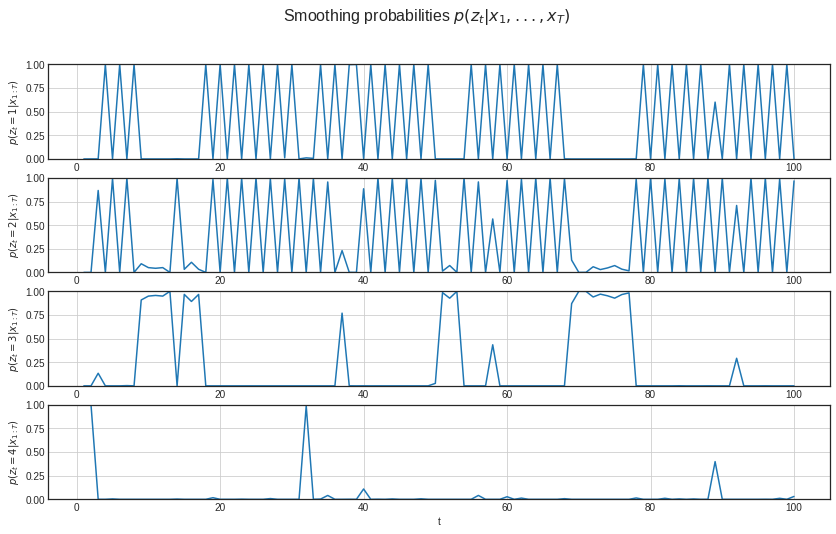

In [8]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
log_eps = log_emission(X_test, mus, sigmas)

# Perform (log) alpha and beta recursions
log_alpha = log_alpha_recursion(X_test, A, log_eps, pi)
log_beta = log_beta_recursion(X_test, A, log_eps)

# Compute smoothing probabilities
gamma = smoothing(log_alpha, log_beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma)

## Expectation-Maximization [20 pts]

### M-step updates
Derive the M-step update for $\hat{\pi}$, $\hat{A}$, $\hat{\mu}_k$ and $\hat{\Sigma}_k$ (for $k=1,\ldots, 4)$ during the EM algorithm, as a function of the quantities computed during the E step. Note that for the estimate of $\pi$, we only have *one* long chain here!

**Answer:**
The estimated log-likelihood with appropriate Lagrange multipliers $\lambda$ and $\eta_\ell$'s is
$$
  \mathcal{L}(X, Z(\theta^{(t)})) = 
  \sum_{k = 1}^K \gamma^{(t)}(z_{1k}) \log \pi^{(t)}_k + 
  \sum_{t = 1}^T \sum_{k = 1}^K \gamma^{(t)}(z_{tk}) \log \mathcal{N}(\mathbf{x}_t, \mu_k, \Sigma_kf) + \sum_{t = 2}^T \sum_{k = 1}^K \sum_{\ell = 1}^K \xi^{(t)}(z_{t-1,\ell},  z_{tk}) \log A_{\ell k} - 
  \lambda \left(\sum_{k = 1}^K \pi_k - 1\right) -
  \sum_{\ell=1}^K \eta_\ell \left(\sum_{k}^K A^{(t)}_{\ell k} - 1\right)
$$
The ML update is found at the extremas of $\mathcal{L}$.

## Bernoulli's prior $\pi_k$
$$
  \nabla_{\pi_\ell} \mathcal{L} = \sum_{k = 1}^K \frac{\gamma^{(t)}(z_{1k})}{\pi_k} \delta_{k\ell} - \lambda 
$$
$$
    \nabla_{\pi_\ell} \mathcal{L}\big\vert_{\hat{\pi}_\ell} = 0  \implies
    \hat{\pi_\ell} = \frac{\gamma^{(t)}(z_{1\ell})}{\lambda}
$$
But, from the normalization condition we get
$$
    \sum_{k = 1}^K \hat{\pi}_k = \frac{1}{\lambda} \sum_{k = 1}^K \gamma^{(t)}(z_{1k}) = 1
$$
Therefore
$$
    \lambda = \sum_{k = 1}^K \gamma^{(t)}(z_{1k})
$$
And
$$
    \boxed{\hat{\pi}_\ell =  \frac{\gamma^{(t)}(z_{1\ell})}{ 
      \displaystyle\sum_{k = 1}^K \gamma^{(t)}(z_{1k})}}
$$

## Transition matrix $A_{\ell k}$
$$
    \nabla_{A_{ij}} \mathcal{L} = 
    \sum_{t = 2}^T \sum_{k = 1}^K \sum_{\ell = 1}^K 
    \xi^{(t)}(z_{t-1,\ell},  z_{tk}) 
    \frac{\delta_{i\ell} \delta_{k j}}{A_{\ell k}}
    -
    \eta_i
$$

$$
    \nabla_{A_{ij}} \mathcal{L}\big\vert_{\hat{A}_{ij}} = 0 \implies 
   \hat{A}_{ij} =  \frac{1}{\eta_i}\sum_{t = 2}^T \xi^{(t)}(z_{t-1,i}, z_{tj})
$$

From the normalization condition,
$$
   \sum_{k=1}^K \hat{A}_{i k} = \frac{1}{\eta_i} \sum_{k=1}^K \sum_{t = 2}^T \xi^{(t)}(z_{t-1,i}, z_{tk}) = 1
$$
Therefore
$$
  \eta_i =  \sum_{t = 2}^T\sum_{k=1}^K \xi^{(t)}(z_{t-1,i}, z_{tk})
$$
And
$$
  \boxed{\hat{A}_{ij} = \frac{\displaystyle \sum_{t = 2}^T \xi^{(t)}(z_{t-1,i}, z_{tj})}{
    \displaystyle \sum_{t = 2}^T\sum_{k=1}^K  \xi^{(t)}(z_{t-1,i}, z_{tk})
  }}
$$

## Mean vectors $\mu_k$
Considering $\mathbf{x}_t$ is a $D$-vector, we have of course
$$
    \log \mathcal{N}(\mathbf{x}_t, \mu_k, \Sigma_k) = 
      -\frac{D}{2}\log(2 \pi) + \frac{1}{2}\log \det \Sigma_k^{-1} 
      -\frac{1}{2}(\mathbf{x}_t - \mu_k)^T \Sigma_k^{-1}(\mathbf{x}_t - \mu_k) 
$$
Therefore,
$$
  \nabla_{\mu_\ell} \mathcal{L} = \sum_{t = 1}^T \sum_{k = 1}^K \gamma^{(t)}(z_{tk}) (\mathbf{x}_t - \mu_k) \Sigma_k^{-1}\delta_{k\ell}
$$
Setting this derivative to zero, we can get rid of the precision matrix $\Sigma_k^{-1}$ by multiplying our equation with the covariance matrix.
$$
  \nabla_{\mu_\ell} \mathcal{L} \big\vert_{\hat{\mu}_\ell} = 0 \implies 
    \boxed{\hat{\mu}_\ell = \frac{
      \displaystyle \sum_{t = 1}^T \gamma^{(t)}(z_{t\ell}) \mathbf{x}_t
    }{\displaystyle \sum_{t = 1}^T \gamma^{(t)}(z_{t \ell})}}
$$

## Covariance matrix $\Sigma_k$

To solve this, we derive w.r.t $\Lambda_\ell = \Sigma_\ell^{-1}$ and use the matrix calculus result
$$
  \frac{d \log \det A}{dA} = A^{-T}
$$
Since the covariance matrix is symmetric, it is equal to its transpose. Therefore,
$$
  \nabla_{\Lambda_{\ell}} \mathcal{L} = \sum_{t = 1}^{T} \sum_{k = 1}^K 
  \gamma^{(t)}(z_{tk})
  \bigg(  \frac{1}{2}\underbrace{\Lambda_k^{-1}}_{\Sigma_k} - \frac{1}{2}(\mathbf{x}_t - \mu_k)(\mathbf{x}_t - \mu_k)^T \bigg)\delta_{k \ell}
$$
Such that
$$
  \nabla_{\Lambda_\ell} \mathcal{L}\big\vert_{\hat{\mu}_\ell, \hat{\Sigma}_\ell} = 0 \implies 
  \boxed{\hat{\Sigma}_\ell
 = \frac{\displaystyle \sum_{t = 1}^T  \gamma^{(t)}(z_{t\ell})
 (\mathbf{x}_t - \hat{\mu}_\ell)(\mathbf{x}_t - \hat{\mu}_\ell)^T
 }{
   \displaystyle \sum_{t = 1}^T \gamma^{(t)}(z_{t\ell})
 }}
 $$


### EM implementation

Implement the EM algorithm to learn the parameters of the model ($\pi,A,\mu_k,\Sigma_k,\: k=1\ldots,4$). Use the parameters from question 2 for initialization.

In [20]:
def log_likelihood(X, pi, A, mus, sigmas):
    gamma, xi = expectation_step(X, pi, A, mus, sigmas)
    T = X.shape[0]
    ll = np.sum(gamma[0] * safe_log(pi))
    ll += np.sum(gamma * log_emission(X, mus, sigmas)) / T
    ll += np.sum(xi * safe_log(A[np.newaxis, ...])) / (T -1)
    return ll

def expectation_step(X, pi, A, mus, sigmas):
    log_eps = log_emission(X, mus, sigmas)
    log_alpha = log_alpha_recursion(X, A, log_eps, pi)
    log_beta  = log_beta_recursion(X, A, log_eps)
    gamma = smoothing(log_alpha, log_beta)
    xi    = pair_marginals(log_alpha, log_beta, A, log_eps)
    return gamma, xi
    

def exp_max(X_tr, X_ts, init_params):
    """
    Estimates the parameters of an HMM using training data X via the EM algorithm

    Inputs:
        X_tr: [T_trainx2] matrix of training observations
        X_tr: [T_testx2] matrix of test observations
        init_params: tuple of initialization parameters from previous question
        
    Returns:
        pi: [K] estimated initial latent distribution
        A: [KxK] estimated transition matrix
        mus: [Kx2] matrix of estimated emission means
        sigmas: [Kx2x2] tensor of estimated emission covariance matrices
        train_avg_llike: list containing the average training log likelihood on each iteration
        test_avg_llike: list containing the average test log likelihood on each iteration
    """

    # Set initialization from parameters given in previous question 
    (K, pi, A, mus, sigmas) = init_params

    train_avg_llike  = []
    test_avg_llike  = []

    # initial log likelihood
    L = log_likelihood(X_tr, pi, A, mus, sigmas)
    train_avg_llike.append(L)
    test_avg_llike.append(log_likelihood(X_ts, pi, A, mus, sigmas))

    # Initialize parameters
    L_prev = L
    max_iter = 50
    epsilon = 1e-3  # tolerance
    for _ in range(max_iter):
        # ====== Expectation step ======
        gamma, xi = expectation_step(X_tr, pi, A, mus, sigmas)

        # ====== Maximization step =====
        pi = gamma[0] / gamma[0].sum()
        A  = xi.sum(axis=0)
        A /= xi.sum(axis=(0, 2))[:, np.newaxis] # normalized over rows
          # mean
        mus = np.sum(gamma[..., np.newaxis] * X_tr[:, np.newaxis, :], axis=0)
        mus /= np.sum(gamma, axis=0)[:, np.newaxis]
          # covariance
        X_centered = X_tr[:, np.newaxis, :] - mus[np.newaxis, ...]
        sigma_empirical = np.einsum("...i, ...j", X_centered, X_centered)
        sigmas = np.sum(gamma[..., np.newaxis, np.newaxis] * sigma_empirical, axis=0)
        sigmas /= np.sum(gamma, axis=0)[:, np.newaxis, np.newaxis]

        # ====== Likelihood and convergence ======
        L = log_likelihood(X_tr, pi, A, mus, sigmas)
        train_avg_llike.append(L)
        test_avg_llike.append(log_likelihood(X_ts, pi, A, mus, sigmas))

        # converged?
        if L < L_prev + epsilon:
            break
        L_prev = L
    print(f"Final log-likelihood train: {L:.2f}")
    print(f"Final log-likelihood test:  {test_avg_llike[-1]:.2f}")

    return pi, A, mus, sigmas, train_avg_llike, test_avg_llike

Learn the parameters of the HMM using the **training** data and plot the average log-likelihood on the train and test data as a function of the iterations of the algorithm. Comment on your observations.

Final log-likelihood train: -3.82
Final log-likelihood test:  -3.95


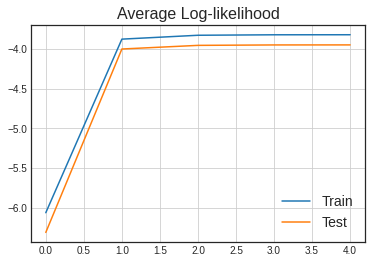

In [21]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Estimate parameters using EM and collect results
res = exp_max(X_train, X_test, INIT_PARAMS)
pi_em, A_em, mus_em, sigmas_em, train_avg_llike, test_avg_llike = res

# Plot the log-likelihoods
plt.plot(train_avg_llike, label='Train')
plt.plot(test_avg_llike, label='Test')
plt.legend(fontsize=14)
plt.grid(True)
plt.title('Average Log-likelihood', fontsize=16)
plt.show()

Complete the following table with the values of the average log-likelihood for the Gaussian mixture models (with a) scaled identities and b) full covariances) and of the HMM on the train and on the test data. 

**Answer:** 

Method | Train Avg. Log-Like | Test Avg. Log-Like
--- | --- | ---
*Scaled Identities GMM* | -5.68 | -5.67
*Full Covariance GMM* | -4.69 | -4.85
*Hidden Markov Model* | -3.82 | -3.95


Does it make sense to make this comparison? Why? If so, what conclusions can you draw?. Moreover, briefly compare these log-likelihoods those obtained for the different models in the previous homework.

**Answer:**


## Viterbi [20 pts]

### Pseudocode

Provide a description and pseudo-code for the Viterbi decoding algorithm (a.k.a. MAP inference algorithm or max-product algorithm) that estimates the most likely sequence of states: $\arg \max_z p(z_1,\dots,z_T | x_1,\dots,x_T)$.

**Answer:**


### Viterbi implementation

Implement Viterbi decoding.

In [22]:
def viterbi(X, pi, A, mus, sigmas):
    """
    Viterbi decoding for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        pi: [Kx1] initial latent state distribution
        A: [KxK] transition matrix
        mus: [Kx2] matrix of latent-conditional emission means
        sigmas: [Kx2x2] tensor of latent-conditional emission covariance matrices
         
    Returns:
        z: [TxK] one-hot encoding of most probable state sequence z_{1:T} given x_{1:T}
    """
    
    T, K = X.shape[0], mus.shape[0]

    # initialization
    log_eps = log_emission(X, mus, sigmas)
    log_delta = np.zeros((T, K))
    log_delta[0] = safe_log(pi) + log_eps[0]
    z = np.zeros((T, K))
    z[0, np.argmax(log_delta[0])] = 1 

    # find the most likely path with max-product algorithm
    for t in range(1, T):
        log_psi = np.max(safe_log(A) + log_delta[t-1], axis=1) + log_eps[t]
        log_delta[t] = np.maximum(log_psi, -16) # log floor
        z[t, np.argmax(log_psi)] = 1
    return z

Using the set of parameters learned with the EM algorithm on the **training** set, compute the most likely sequence of states for the **training** data with the Viterbi algorithm. Plot your results.

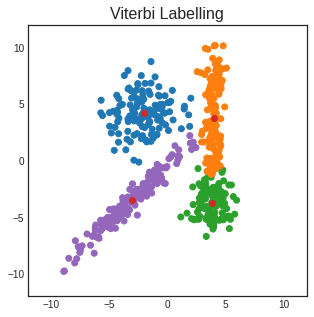

In [23]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
one_hot_labels =  viterbi(X_train, pi_em, A_em, mus_em, sigmas_em)
viterbi_labels =  np.argmax(one_hot_labels, axis=1)

# Plot the results
plot_labelling(X_train, viterbi_labels, mus, 'Viterbi Labelling')

## Comparing methods [20 pts]

Use the parameters learned using EM on the **training** set to compute the smoothing marginal probability $p(z_t|x_1,\dots,x_T)$ for each datapoint in the **test** set to be in state $\{1,2,3,4\}$. Plot the probability of being in that state as a function of time for the 100 first points, as before.

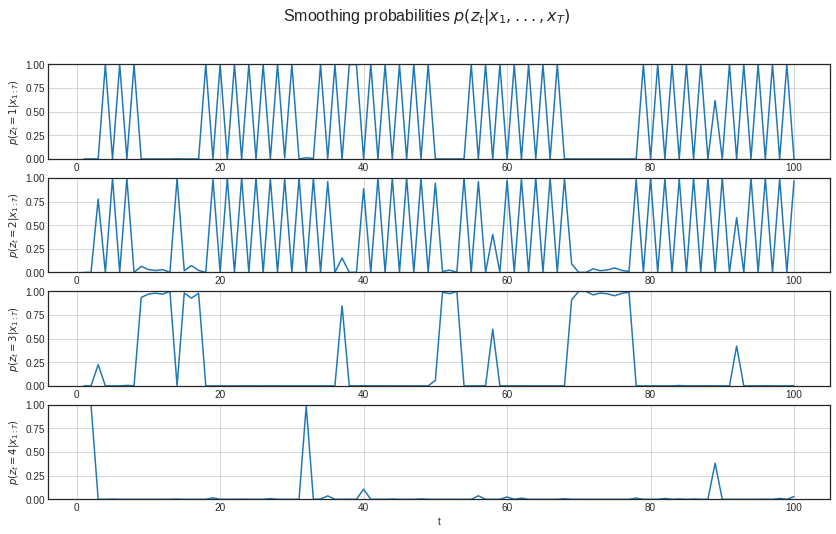

In [24]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
log_eps = log_emission(X_test, mus_em, sigmas_em)

# Perform (log) alpha and beta recursions
log_alpha = log_alpha_recursion(X_test, A_em, log_eps, pi_em)
log_beta = log_beta_recursion(X_test, A_em, log_eps)

# Compute smoothing probabilities
gamma = smoothing(log_alpha, log_beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma)

For each of these same 100 points, compute their most likely state according to the marginal probability computed in the previous question. Make a plot representing the most likely state in $\{1,2,3,4\}$ as function of time for these 100 points.

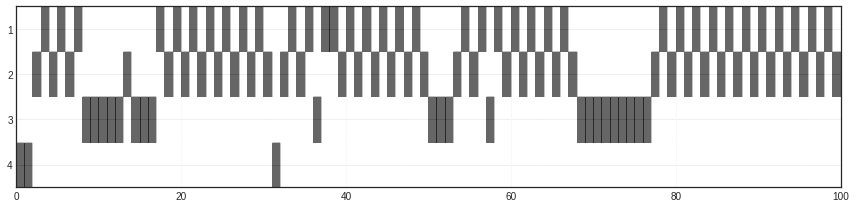

In [14]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

plot_dominoes(gamma)

Run Viterbi on the **test** data. Make a similar plot.

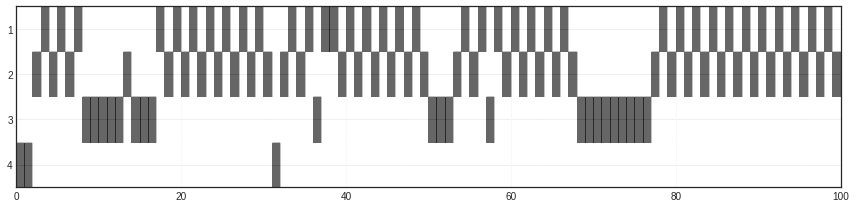

In [15]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
one_hot_labels = viterbi(X_test, pi_em, A_em, mus_em, sigmas_em)

# Plot the results
plot_dominoes(one_hot_labels)

Compare the most likely sequence of states obtained for the 100 first data points with the sequence of states obtained in the previous question. Comment on your observations.

**Answer:**


## What about $K$? [5 pts]

In this problem the number of states $K$ was known. How should one choose the number of states if it is unknown a priori?

**Answer:** 
